In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("/Users/bytedance/MLTrader-deploy/")
import sys
sys.path.insert(0, ".")
import research.orderbook_strategies.utils.helper as helper
import research.orderbook_strategies.utils.stats as stats
import research.orderbook_strategies.utils.factor_analysis as factor_analysis
import research.orderbook_strategies.utils.factors as factors
from dask.diagnostics import ProgressBar
from imp import reload   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew

In [3]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')

product_list = ["OPUSDT","BTCUSDT", "ETHUSDT", "APTUSDT", "1000PEPEUSDT"]

In [18]:
reload(factors)
x1 = factors.foctor_ret_period_002()
x2 = factors.foctor_ret_period_004()
x3 = factors.foctor_ret_period_001()
x4 = factors.foctor_ret_period()

factor_list = [x1, x2, x3, x4]
for product in product_list:
    file_list = helper.get_file_list(product)
    with ProgressBar():
        helper.parLapply(file_list, 
                         factor_analysis.build_composite_signal,
                         signal_list=factor_list, 
                         product=product,
                         overwrite=True)

[########################################] | 100% Completed | 37.17 s
[########################################] | 100% Completed | 30.55 s
[########################################] | 100% Completed | 38.48 s
[########################################] | 100% Completed | 27.09 s
[########################################] | 100% Completed | 10.15 s


In [29]:
dire_signal_list = ["kdj.j", "buy_power", "adx.direc2.1024", "rmi", "volume.advantage",
                    "kdj.k", "ma.dif.10", "dbook", "range.pos", "nr",
                    "dbook.spread.diff", "dbook.spread"]

range_signal_list = ["std", "trend.index", "atr", "adx.1024", ""]

In [30]:
all_signal_list = np.array([])
period_list = [32, 64, 128, 256, 512, 1024, 2048]
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal +".2048"
        all_signal_list = np.append(all_signal_list,signal_name)
signal_with_period_list = [signal+".{}".format(period) for period in period_list for signal in all_signal_list ]

In [31]:
print("#features=", len(signal_with_period_list))

#features= 420


In [32]:
# skip this cell if you have already run it before

# for product in product_list:
#     all_dates = helper.get_dates_list(product)
#     with ProgressBar():
#         helper.parLapply(["ret.512", "ret.512.001", "ret.512.002", "ret.512.004"],  helper.par_generate_alldates_signal, date_list=all_dates, product=product, period=512, overwrite=True)
        
# for product in product_list:
#     all_dates = helper.get_dates_list(product)
#     with ProgressBar():
#         helper.parLapply(["ret.256", "ret.256.001", "ret.256.002", "ret.256.004"],  helper.par_generate_alldates_signal, date_list=all_dates, product=product, period=256, overwrite=True)

In [33]:
# ret1 = helper.auto_get_alldates_signal("ret.512", "1000PEPEUSDT")
# ret2 = helper.auto_get_alldates_signal("ret.512.001", "1000PEPEUSDT")
# ret3 = helper.auto_get_alldates_signal("ret.512.002", "1000PEPEUSDT")
# ret4 = helper.auto_get_alldates_signal("ret.512.004", "1000PEPEUSDT")

In [34]:
# ret1[np.isnan(ret1)] = 0
# ret2[np.isnan(ret2)] = 0
# ret3[np.isnan(ret3)] = 0
# ret4[np.isnan(ret4)] = 0
# print("kurtosis=", kurtosis(ret1.astype(float), fisher=False), " skew=", skew(ret1.astype(float)))
# print("kurtosis=", kurtosis(ret2.astype(float), fisher=False), " skew=", skew(ret2.astype(float)))
# print("kurtosis=", kurtosis(ret3.astype(float), fisher=False), " skew=", skew(ret3.astype(float)))
# print("kurtosis=", kurtosis(ret4.astype(float), fisher=False), " skew=", skew(ret4.astype(float)))

'''
kurtosis= 56.2914288712756  skew= -1.3140446916599293
kurtosis= 3.746235615530634  skew= 0.005540007954575688
kurtosis= 6.0532835796738  skew= 0.04924502907261453
kurtosis= 11.206226311646109  skew= 0.07100890894123325
'''

'\nkurtosis= 56.2914288712756  skew= -1.3140446916599293\nkurtosis= 3.746235615530634  skew= 0.005540007954575688\nkurtosis= 6.0532835796738  skew= 0.04924502907261453\nkurtosis= 11.206226311646109  skew= 0.07100890894123325\n'

In [35]:
# plt.figure(1, figsize=(16, 10))
# plt.plot(ret1);

## 准备因子矩阵

In [36]:
from tqdm.notebook import tqdm
label_period = 512
label_signal_list = [f"ret.{label_period}", 
                     f"ret.{label_period}.001", 
                     f"ret.{label_period}.002", 
                     f"ret.{label_period}.004"]

# skip this cell if you have already run it
for product in product_list:
    if product != "1000PEPEUSDT":
        continue
    
    print("processing ", product)
    train_signals_by_product = {}
    test_signals_by_product  = {}
    dates = helper.get_dates_list(product)
    split_date = "2023-06-10" if product == "1000PEPEUSDT" else "2023-04-01"
    train_dates = [date for date in dates if date <= split_date]
    test_dates = [date for date in dates if date > split_date]
    for signal in tqdm(set(list(signal_with_period_list) + label_signal_list)):
        train_signal = helper.get_good_signal(product, 
                                        signal, 
                                        date_from=min(train_dates), 
                                        date_to=max(train_dates))
        test_signal = helper.get_good_signal(product, 
                                            signal,
                                            date_from=min(test_dates),
                                            date_to=max(test_dates))
        train_signal = train_signal[::label_period]
        test_signal = test_signal[::label_period]
        
        train_signals_by_product[signal] = train_signal
        test_signals_by_product[signal] = test_signal
        
    df = pd.DataFrame(train_signals_by_product)
    test_df = pd.DataFrame(test_signals_by_product)
    helper.save(df, helper.get_cache_path("signals_matrix_by_product") / product / "train_df.pd_pkl")
    helper.save(test_df, helper.get_cache_path("signals_matrix_by_product") / product / "test_df.pd_pkl")

processing  1000PEPEUSDT


  0%|          | 0/424 [00:00<?, ?it/s]

In [37]:
product = "1000PEPEUSDT"
train_df = helper.load(helper.get_cache_path("signals_matrix_by_product") / product / "train_df.pd_pkl")
test_df = helper.load(helper.get_cache_path("signals_matrix_by_product") / product / "test_df.pd_pkl")

In [38]:
print("Shape of Train={}, Shape of Test Data={}".format(train_df.shape, test_df.shape))

Shape of Train=(5842, 424), Shape of Test Data=(9415, 424)


# 用t统计量来筛选因子对比一下有效性

In [39]:
import statsmodels.formula.api as smf

In [40]:
feature_list = signal_with_period_list
label = 'ret.512'
print(list(sorted(feature_list)))

['adx.direc2.1024.1024', 'adx.direc2.1024.128', 'adx.direc2.1024.2048', 'adx.direc2.1024.256', 'adx.direc2.1024.32', 'adx.direc2.1024.512', 'adx.direc2.1024.64', 'adx.direc2.1024.adx.1024.2048.1024', 'adx.direc2.1024.adx.1024.2048.128', 'adx.direc2.1024.adx.1024.2048.2048', 'adx.direc2.1024.adx.1024.2048.256', 'adx.direc2.1024.adx.1024.2048.32', 'adx.direc2.1024.adx.1024.2048.512', 'adx.direc2.1024.adx.1024.2048.64', 'adx.direc2.1024.atr.2048.1024', 'adx.direc2.1024.atr.2048.128', 'adx.direc2.1024.atr.2048.2048', 'adx.direc2.1024.atr.2048.256', 'adx.direc2.1024.atr.2048.32', 'adx.direc2.1024.atr.2048.512', 'adx.direc2.1024.atr.2048.64', 'adx.direc2.1024.std.2048.1024', 'adx.direc2.1024.std.2048.128', 'adx.direc2.1024.std.2048.2048', 'adx.direc2.1024.std.2048.256', 'adx.direc2.1024.std.2048.32', 'adx.direc2.1024.std.2048.512', 'adx.direc2.1024.std.2048.64', 'adx.direc2.1024.trend.index.2048.1024', 'adx.direc2.1024.trend.index.2048.128', 'adx.direc2.1024.trend.index.2048.2048', 'adx.dire

In [41]:
formula = "train_df['ret.512'] ~ train_df['nr.512'] + 0"
fit_one_lm = smf.ols(formula=formula, data=train_df).fit()
print(fit_one_lm.summary())

                                 OLS Regression Results                                 
Dep. Variable:     train_df['ret.512']   R-squared (uncentered):                   0.000
Model:                             OLS   Adj. R-squared (uncentered):             -0.000
Method:                  Least Squares   F-statistic:                             0.6094
Date:                 Mon, 04 Sep 2023   Prob (F-statistic):                       0.435
Time:                         20:30:36   Log-Likelihood:                          18926.
No. Observations:                 5842   AIC:                                 -3.785e+04
Df Residuals:                     5841   BIC:                                 -3.784e+04
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

                                 OLS Regression Results                                 
Dep. Variable:     train_df['ret.512']   R-squared (uncentered):                   0.000
Model:                             OLS   Adj. R-squared (uncentered):             -0.000
Method:                  Least Squares   F-statistic:                             0.6094
Date:                 Wed, 16 Aug 2023   Prob (F-statistic):                       0.435
Time:                         23:25:42   Log-Likelihood:                          18926.
No. Observations:                 5842   AIC:                                 -3.785e+04
Df Residuals:                     5841   BIC:                                 -3.784e+04
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [42]:
def get_t_value(train_mat, signal, response):
    beta = np.sum(train_mat[signal]*train_mat[response])/sum(train_mat[signal]**2) ## regressio coef
    sigma = np.sqrt(np.sum((train_mat[signal]*beta-train_mat[response])**2) / (len(train_mat)-1)) 
    v = np.sqrt(np.sum(train_mat[signal]**2)) ## sigma/v is the standard devication of beta_hat
    return beta/sigma*v

In [43]:
t_stat = list(map(lambda x: get_t_value(train_mat=train_df, signal=x, response="ret.512"), feature_list))
t_stat = pd.DataFrame(t_stat, index=feature_list, columns=["t_stat"])

t_stat_test = list(map(lambda x: get_t_value(train_mat=test_df, signal=x, response="ret.512"), feature_list))
t_stat_test = pd.DataFrame(t_stat_test, index=feature_list, columns=["t_stat"])

In [44]:
good_signals_in_backtesting = ['kdj.k.trend.index.2048.32', 'dbook.trend.index.2048.32', 'dbook.spread.diff.std.2048.32', 'kdj.j.trend.index.2048.32', 'nr.trend.index.2048.32', 'dbook.spread.diff.std.2048.64', 'volume.advantage.trend.index.2048.32', 'kdj.k.trend.index.2048.64', 'dbook.trend.index.2048.64', 'dbook.std.2048.32', 'range.pos.trend.index.2048.32', 'nr.trend.index.2048.64', 'kdj.j.trend.index.2048.64', 'dbook.spread.diff.std.2048.128', 'rmi.trend.index.2048.32', 'kdj.k.std.2048.32', 'kdj.k.trend.index.2048.128', 'volume.advantage.trend.index.2048.64', 'kdj.j.std.2048.32', 'nr.trend.index.2048.128', 'volume.advantage.std.2048.32', 'range.pos.trend.index.2048.64', 'kdj.j.trend.index.2048.128', 'dbook.spread.diff.std.2048.256', 'rmi.trend.index.2048.64', 'adx.direc2.1024.trend.index.2048.32', 'dbook.trend.index.2048.128', 'nr.trend.index.2048.256', 'nr.std.2048.32', 'ma.dif.10.std.2048.32', 'kdj.k.trend.index.2048.256', 'adx.direc2.1024.trend.index.2048.64', 'ma.dif.10.trend.index.2048.32', 'volume.advantage.trend.index.2048.128', 'dbook.std.2048.64', 'adx.direc2.1024.trend.index.2048.128', 'range.pos.std.2048.32', 'kdj.k.std.2048.64', 'kdj.j.trend.index.2048.256', 'range.pos.trend.index.2048.128', 'rmi.trend.index.2048.128', 'dbook.spread.diff.std.2048.512', 'volume.advantage.std.2048.64', 'rmi.std.2048.32', 'nr.std.2048.64', 'kdj.j.std.2048.64', 'kdj.k.trend.index.2048.512', 'adx.direc2.1024.trend.index.2048.256', 'volume.advantage.trend.index.2048.256', 'ma.dif.10.trend.index.2048.64']

In [45]:
good_signals = list(t_stat.query("t_stat > 1").index)
print("#good signals=", len(good_signals))

#good signals= 69


In [46]:
t = (t_stat_test.loc[good_signals] > 1).sum().item()
print("Train 得分不错的signal 存活={}/{}".format(t, len(good_signals)))


Train 得分不错的signal 存活=22/69


In [50]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler

# 开始建模 使用 t-test Lasso

In [47]:
product = "1000PEPEUSDT"
feature_list = signal_with_period_list
# feature_list = good_signals
# feature_list = good_signals_in_backtesting
label_name = 'ret.512.004'
train_df = helper.load(helper.get_cache_path("signals_matrix_by_product") / product / "train_df.pd_pkl")
test_df = helper.load(helper.get_cache_path("signals_matrix_by_product") / product / "test_df.pd_pkl")


In [51]:
x_train = train_df[feature_list]
y_train = train_df[label_name]
x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0, ddof=1)
x_train_normal = (x_train - x_mean) / x_std
y_std = np.std(y_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train/y_std)
coef = model.coef_/x_std*y_std
bias = - np.sum(model.coef_ * y_std / x_std * x_mean)
res = pd.DataFrame({'feature': feature_list, 'coef': coef})

In [53]:
# train r_2
r2_train = model.score(x_train_normal, y_train/y_std)
# train r_2
x_test_normalized = (test_df[feature_list] - x_mean)/x_std
y_test = test_df[label_name]
r2_test = model.score(x_test_normalized, y_test/y_std)

In [148]:
print("train/test r2={}/{}".format(r2_train, r2_test))

train/test r2=0.0005882511343746621/0.0004690784103490442


In [54]:
res.query("coef != 0")

,feature,coef
buy_power.32,buy_power.32,-0.000013
kdj.j.atr.2048.64,kdj.j.atr.2048.64,0.003634
adx.direc2.1024.atr.2048.64,adx.direc2.1024.atr.2048.64,-0.000218
ma.dif.10.adx.1024.2048.64,ma.dif.10.adx.1024.2048.64,-0.001242
ma.dif.10.atr.2048.128,ma.dif.10.atr.2048.128,-0.005999
kdj.k.std.2048.1024,kdj.k.std.2048.1024,0.005849
adx.direc2.1024.atr.2048.1024,adx.direc2.1024.atr.2048.1024,-0.002917
dbook.atr.2048.1024,dbook.atr.2048.1024,0.116119
range.pos.adx.1024.2048.2048,range.pos.adx.1024.2048.2048,-0.000853


In [55]:
coef_dict = {}
for signal_name in feature_list:
    coef = res.loc[signal_name, 'coef']
    if  coef != 0:
        coef_dict[signal_name] = coef

In [56]:
date_list = helper.get_dates_list(product)
with ProgressBar():
    helper.parLapply(date_list, 
                    helper.par_get_daily_pred,
                    product=product,
                    coef=coef_dict,
                    bias=bias,
                    strat="lasso.full.512",
                    overwrite=True
                    )

[                                        ] | 0% Completed | 3.39 s mscreate /Volumes/AdamDrive/experiment_root/orderbook_research/signal/1000PEPEUSDT/lasso.full.512
[########################################] | 100% Completed | 4.44 s


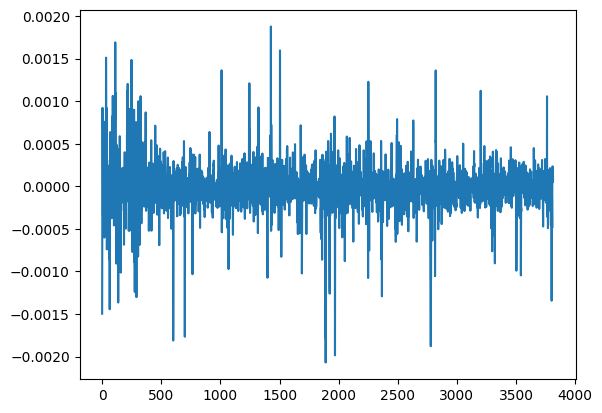

In [57]:
import matplotlib.pyplot as plt
all_dates = np.array(helper.get_dates_list(product))
helper.par_generate_alldates_signal('lasso.full.512', all_dates, product, 2048, overwrite=True)

signal = helper.auto_get_alldates_signal("lasso.full.512", product)
plt.plot(signal)

In [59]:
spread = helper.product_info[product]["spread"]
tranct = 0
tranct_ratio = helper.product_info[product]["tranct.ratio"]
all_dates = np.array(helper.get_dates_list(product))
if product == "1000PEPEUSDT":
    split_str = "2023-06-10"
else:
    split_str = "2023-04-01"
factor_analysis.evaluate_signal("lasso.full", all_dates, product,
                                period=512,
                                split_str=split_str,
                                tranct=tranct,
                                max_spread=spread*1.8,
                                tranct_ratio=0.,
                                atr_filter=0.01,  # 波动大于1%
                                save_path="signal_result_with_atr",
                                overwrite=True,
                                reverse=1)

evaludating signal trend 1000PEPEUSDT lasso.full.512 done


In [60]:
trend_results = helper.load(helper.SIGNAL_RESULTS_PATH / 'signal_result_with_atr' / f"{product}.lasso.full.512.trend.pkl")

In [66]:
trend_results["train.stat"]['final_result'].sort_values(by=['open'])[["open", "close", "avg.num", "avg.ret", 'sharpe.ret']]

,open,close,avg.num,avg.ret,sharpe.ret
open_close,,,,,
0.00023735528215196842_-0.00014241316929118104,0.000237,-0.000142,47.171429,0.000313,1.984557
0.00023735528215196842_-0.00018988422572157476,0.000237,-0.000190,41.971429,0.000515,2.546711
0.00023735528215196842_-0.00023735528215196842,0.000237,-0.000237,36.828571,0.000573,2.725908
0.00023735528215196842_-4.747105643039369e-05,0.000237,-0.000047,63.171429,0.000377,3.168411
0.00023735528215196842_-9.494211286078738e-05,0.000237,-0.000095,54.714286,0.000435,3.031540
0.0002743144160264315_-0.00010972576641057262,0.000274,-0.000110,45.200000,0.000452,2.551274
0.0002743144160264315_-0.0001645886496158589,0.000274,-0.000165,39.142857,0.000414,2.002814
0.0002743144160264315_-0.00021945153282114523,0.000274,-0.000219,34.514286,0.000728,3.138838
0.0002743144160264315_-0.0002743144160264315,0.000274,-0.000274,29.000000,0.000441,1.552286


In [67]:
# overfits a lot
trend_results["test.stat"]['final_result'].sort_values(by=['open'])[["open", "close", "avg.num", "avg.ret", 'sharpe.ret']]

,open,close,avg.num,avg.ret,sharpe.ret
open_close,,,,,
0.00023735528215196842_-0.00014241316929118104,0.000237,-0.000142,21.366667,-0.000633,-3.465379
0.00023735528215196842_-0.00018988422572157476,0.000237,-0.000190,18.350000,-0.000799,-3.736223
0.00023735528215196842_-0.00023735528215196842,0.000237,-0.000237,15.933333,-0.000969,-3.926307
0.00023735528215196842_-4.747105643039369e-05,0.000237,-0.000047,30.366667,-0.000260,-2.247298
0.00023735528215196842_-9.494211286078738e-05,0.000237,-0.000095,25.750000,-0.000332,-2.207202
0.0002743144160264315_-0.00010972576641057262,0.000274,-0.000110,20.350000,-0.000607,-3.367856
0.0002743144160264315_-0.0001645886496158589,0.000274,-0.000165,17.450000,-0.000743,-3.583342
0.0002743144160264315_-0.00021945153282114523,0.000274,-0.000219,14.600000,-0.001238,-4.579943
0.0002743144160264315_-0.0002743144160264315,0.000274,-0.000274,12.583333,-0.001312,-4.162954


In [166]:
top_train_res = trend_results["train.stat"]['final_result'].sort_values(by='sharpe.ret', ascending=False).head(5).index
trend_results["test.stat"]['final_result'].loc[top_train_res, ["open", "sharpe.ret", "avg.ret", "avg.num", 'profit_factor', 'win_rate']]

,open,sharpe.ret,avg.ret,avg.num,profit_factor,win_rate
open_close,,,,,,
0.0006686997430329041_-0.0006686997430329041,0.000669,0.349190,0.004003,0.116667,1.003270,0.499633
0.000409780035272524_-0.00016391201410900961,0.000410,0.945391,0.000575,3.466667,0.976109,0.508217
0.000409780035272524_-8.195600705450481e-05,0.000410,1.940767,0.000631,4.300000,0.930373,0.524102
0.0006686997430329041_-0.00040121984581974245,0.000669,1.090218,0.008351,0.116667,1.002747,0.499733
0.00034542559017873667_-6.908511803574733e-05,0.000345,1.892016,0.000412,6.733333,0.912136,0.528508


In [123]:
res = factor_analysis.get_signal_performance_result(['lasso.512'], "signal_result_with_atr", [product], min_avg_pnl=0.0004, min_trade_num=1)
trend = res["trend.signal.stat"]
reverse = res["reverse.signal.stat"]